<a href="https://colab.research.google.com/github/morganmcg1/reformer-fastai/blob/main/exploration/lm_generation_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip install -Uqq fastai einops datasets

     |████████████████████████████████| 194kB 11.9MB/s 
     |████████████████████████████████| 153kB 28.1MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 245kB 18.6MB/s 
     |████████████████████████████████| 17.7MB 207kB/s 


In [2]:
from fastai.text.all import *
import datasets
from datasets import load_dataset
import six

In [3]:
dataset = load_dataset('tiny_shakespeare')

Using custom data configuration default


Dataset tiny_shakespeare downloaded and prepared to /root/.cache/huggingface/datasets/tiny_shakespeare/default/1.0.0/da11b9a200ca715af415094b34d5c956170f184cb3a58d7789680cf81bede955. Subsequent calls will reuse this data.


In [4]:
train_ds = dataset['train']

In [5]:
def splitlines(sample):
    return {'line':[*sample['text'][0].split('\n')]}

In [6]:
train_ds = train_ds.map(splitlines, batched=True, remove_columns=['text'])

In [7]:
train_ds = train_ds.filter(lambda x: x['line'] != '')

In [8]:
train_ds[:10]

OrderedDict([('line',
              ['First Citizen:',
               'Before we proceed any further, hear me speak.',
               'All:',
               'Speak, speak.',
               'First Citizen:',
               'You are all resolved rather to die than to famish?',
               'All:',
               'Resolved. resolved.',
               'First Citizen:',
               'First, you know Caius Marcius is chief enemy to the people.'])])

In [9]:
df = train_ds.data.to_pandas()
df.head()

,line
0,First Citizen:
1,"Before we proceed any further, hear me speak."
2,All:
3,"Speak, speak."
4,First Citizen:


In [10]:
class ByteTextTokenizer(Transform):
    """
        Encodes each byte to an id. For 8-bit strings only.
        Credit: https://github.com/tensorflow/tensor2tensor/blob/5f9dd2db6d7797162e53adf152310ed13e9fc711/tensor2tensor/data_generators/text_encoder.py#L176
    """
    def __init__(self, is_lm=True, add_bos=False, add_eos=False):
        self.ls_lm = is_lm
        self.add_bos, self.add_eos = add_bos, add_eos
        self.pad_token, self.eos_token, self.bos_token = '<pad>', '<eos>', '<bos>',
        self.pad_token_id, self.eos_token_id, self.bos_token_id = 0,1,2
        self.reserved_toks = [self.pad_token, self.eos_token, self.bos_token]  ## self.bos_token_id 
        self.reserved_tokens_bytes = [bytes(rtok, 'ascii') for rtok in self.reserved_toks]
        self.numres = len(self.reserved_toks)
        self.int2byte = six.int2byte

    @typedispatch
    def __call__(self, o:list, **kwargs):
        out = [c + self.numres for s in o for c in s.encode("utf-8")]
        if self.add_bos: out = [self.bos_token_id] + out
        if self.add_eos: out =  out + [self.eos_token_id]
        if self.ls_lm:return LMTensorText(out)
        else: return TensorText(out) 
        
    @typedispatch
    def __call__(self, o:str, **kwargs):
        out = [c + self.numres for c in o.encode("utf-8")]
        if self.add_bos: out = [self.bos_token_id] + out
        if self.add_eos: out =  out + [self.eos_token_id]
        if self.ls_lm:return LMTensorText(out)
        else: return TensorText(out) 
    
    def encodes(self,o):
        return self.__call__(o)
    
    def decodes(self, o:tuple):
        decoded_ids = ()
        for i in o:
            tmp_ls=[]
            for id_ in i:
                if 0 <= id_ < self.numres: tmp_ls.append(self.reserved_tokens_bytes[int(id_)])
                else: tmp_ls.append(self.int2byte(id_ - self.numres))
            decoded_ids = decoded_ids + (b"".join(tmp_ls).decode("utf-8", "replace"),)
        return TitledStr(decoded_ids)
    
    def decodes(self, o:list):
        decoded_ids = []
        for id_ in o:
            if 0 <= id_ < self.numres: decoded_ids.append(self.reserved_tokens_bytes[int(id_)])
            else: decoded_ids.append(self.int2byte(id_ - self.numres))
        return TitledStr(b"".join(decoded_ids).decode("utf-8", "replace"))
    
    def decodes(self, o:TensorText):
        return self.decodes(o.tolist())
    
    def decodes(self, o:LMTensorText):
        return self.decodes(o.tolist())
    
    @property
    def vocab_size(self): return 2**8 + self.numres

In [11]:
bte = ByteTextTokenizer(is_lm=True, add_bos=True, add_eos=True)

In [12]:
@patch
def create_item(self:LMDataLoader, seq):
    if seq>=self.n: raise IndexError
    sl = self.last_len if seq//self.bs==self.n_batches-1 else self.seq_len
    st = (seq%self.bs)*self.bl + (seq//self.bs)*self.seq_len
    txt = self.chunks[st : st+sl+1]    
    return LMTensorText(txt[:-1]),txt[1:]
    # return LMTensorText(txt[:-1].tolist()+[1]), LMTensorText(txt[1:].tolist()+[1])   ## ADD EOS TOKEN

In [13]:
cut = int(len(df)*0.8)
splits = range_of(df)[:cut], range_of(df[cut:])

In [14]:
tfms = [attrgetter("line"), bte]
dsets = Datasets(df, [tfms, tfms], splits=splits, dl_type=LMDataLoader)

In [15]:
dsets[0]

(LMTensorText([  2,  73, 108, 117, 118, 119,  35,  70, 108, 119, 108, 125, 104, 113,
          61,   1]),
 LMTensorText([  2,  73, 108, 117, 118, 119,  35,  70, 108, 119, 108, 125, 104, 113,
          61,   1]))

In [16]:
bte.decode(_[0])

'<bos>First Citizen:<eos>'

In [17]:
bs,sl = 32,128
pad_seq2seq = partial(pad_input, pad_idx=bte.pad_token_id, pad_fields=[0,1])

dls = dsets.dataloaders(bs=bs, seq_len=sl, before_batch=pad_seq2seq)

In [18]:
dls.show_batch(max_n=2)

,text,text_
0,"<bos>From slaves that apes would beat! Pluto and hell!<eos><bos>Say that again.<eos><bos>It seem'd, appear'd to Rome. By the discovery.<eos><bos>favour is w","From slaves that apes would beat! Pluto and hell!<eos><bos>Say that again.<eos><bos>It seem'd, appear'd to Rome. By the discovery.<eos><bos>favour is we"
1,;<eos><bos>What sayest thou? speak suddenly; be brief.<eos><bos>KING RICHARD III:<eos><bos>To do that office of thine own good will<eos><bos>Which being shallow,"<eos><bos>What sayest thou? speak suddenly; be brief.<eos><bos>KING RICHARD III:<eos><bos>To do that office of thine own good will<eos><bos>Which being shallow,"


In [19]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([32, 128]), torch.Size([32, 128]))

In [21]:
from basic_transformer import TransformerLM

In [22]:
vocab_sz = bte.vocab_size

In [23]:
learn = Learner(dls, TransformerLM(vocab_sz, 512),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, Perplexity()]).to_fp16()

SuggestedLRs(lr_min=0.0005248074419796466, lr_steep=9.120108734350652e-05)

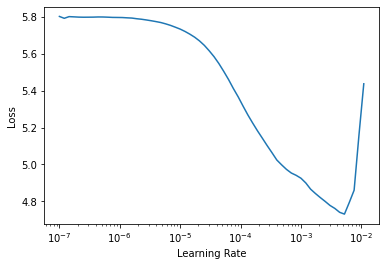

In [24]:
learn.lr_find()

In [25]:
learn.fit_one_cycle(10, 5e-4, wd=0.05)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.390857,3.305515,0.148283,27.262579,00:58
1,2.787714,2.568908,0.269077,13.051570,00:57
2,2.442619,2.289567,0.335838,9.870661,00:58
3,2.147150,1.998491,0.407134,7.377917,00:58
4,1.913086,1.782490,0.466074,5.944638,00:57
5,1.758352,1.645201,0.501062,5.182051,00:57
6,1.664547,1.563624,0.522649,4.776098,00:58
7,1.603912,1.518484,0.536574,4.565301,00:58
8,1.573059,1.497036,0.543169,4.468424,00:57
9,1.560909,1.490661,0.544189,4.440031,00:57


In [26]:
learn.save('shakespeare_e10')

Path('models/shakespeare_e10.pth')

In [ ]:
learn.load('shakespeare_e10')

## Generation

In [27]:
# credit https://github.com/huggingface/transformers/blob/a0c62d249303a68f5336e3f9a96ecf9241d7abbe/src/transformers/generation_logits_process.py
def top_p_filter(logits, top_p=0.9):
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    cum_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

    sorted_indices_to_remove = cum_probs > top_p
    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
    sorted_indices_to_remove[..., 0] = 0
    # if min_tokens_to_keep > 1:
    #         # Keep at least min_tokens_to_keep (set to min_tokens_to_keep-1 because we add the first one below)
    #         sorted_indices_to_remove[..., : min_tokens_to_keep - 1] = 0
    indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
    scores[indices_to_remove] = float('-inf')
    return scores

def top_k_filter(logits, top_k=20):
    indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
    logits[indices_to_remove] = float('-inf')
    return logits

In [28]:
_sampler = {
    'top_k':top_k_filter,
    'top_p':top_p_filter,
    'gready':lambda x: x.argmax(-1)
}

In [29]:
@torch.no_grad()
def generate(model,
             inp,
             max_len=50,
             temperature=1.,
             method = 'top_k',
             top_k = 20,
             top_p = 0.9,
             early_stopping=False):
    model.eval()
    thresh = top_k if method=='top_k' else top_p
    sampler = _sampler[method]

    if len(inp.shape) == 1:
        inp = inp[None, :]
    b, t = inp.shape
    out = inp
    
    for _ in range(max_len):
        x = out[:, -model.max_seq_len:]

        logits = model(x)[:, -1, :]
        if method == 'greedy':
            sample = sampler(logits)
        else:
            filtered_logits = sampler(logits)
            probs = F.softmax(filtered_logits / temperature, dim=-1)
            sample = torch.multinomial(probs, 1)

        out = torch.cat((out, sample), dim=-1)

        if early_stopping and (sample == bte.eos_token_id).all():
            break
    # out = out[:, t:]
    return out

In [34]:
out = generate(learn.model, tensor([[2]]).cuda(),
               max_len = 100,
               early_stopping=False,
               temperature=1.)

In [35]:
[bte.decode(x.cpu().tolist()) for x in out]

['<bos>CLIFFORD:<eos><bos>And lords you are take much a dege;<eos><bos>Frown, meast may the kind me, good noble in his:<eos><bos>Fr']